# Уравнение и схемы
Рассматриваем уравнение НУШ в каноническом виде:

i∂u/∂z + (1/2)∂²u/∂t² + |u|²u = 0

## Cхема Ричардсона

In [50]:
def richardson_scheme(u_prev, u_curr, dt, dz, Nt, Nz):
    u_next = np.zeros_like(u_curr, dtype=complex)
    for j in range(1, Nt-1):
        # Дискретизация производных согласно схеме Ричардсона
        laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
        nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
        
        # Формула схемы Ричардсона (O(τ²,h²))
        u_next[j] = u_prev[j] - 1j*dz*(0.5*laplacian + nonlinear)
    
    # Граничные условия (свободные)
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

## Трехслойная схема с весами:

In [74]:
def three_layer_scheme(u_prev, u_curr, dt, dz, Nt, Nz, sigma=0.5):
    r = -dt/dz**2
    sigma = 1/2 - 1j/12/r
    u_next = np.zeros_like(u_curr, dtype=complex)
    for n in range(1, Nz-1):
        for j in range(1, Nt-1):
            # Дискретизация производных
            laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
            nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
            
            # Трехслойная схема
            u_next[j] = u_prev[j] - 1j*dz*(
                sigma*(0.5*laplacian + nonlinear) + 
                (1-sigma)*(0.5*(u_curr[j+1]-2*u_curr[j]+u_curr[j-1])/dt**2 + np.abs(u_curr[j])**2*u_curr[j])
            )
    
    # Граничные условия
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

## Двухслойная явная схема:

In [75]:
def two_layer_explicit(u_curr, dt, dz, Nt, Nz):
    u_next = np.zeros_like(u_curr, dtype=complex)
    for j in range(1, Nt-1):
        laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
        nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
        u_next[j] = u_curr[j] - 1j*dz*(0.5*laplacian + nonlinear)
    
    # Граничные условия
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

# Исследование эволюции начальных распределений

In [262]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
Lz = 10.0  # длина по z
Lt = 20.0  # длина по t (от -10 до 10)
Nz = 500 # количество точек по z
Nt = 50   # количество точек по t
dz = Lz/Nz
dt = Lt/Nt

print(dz/dt**2)

# Сетка
z = np.linspace(0, Lz, Nz)
t = np.linspace(-Lt/2, Lt/2, Nt)

# Начальные условия
u_gaussian = np.exp(-t**2/2)  # Гауссов импульс
u_sech = 1.2 / np.cosh(t)      # Гиперболический секанс

# Решение с трехслойной схемой
def solve_NLS(u0, scheme, dz, dt, Nz, Nt):
    u = np.zeros((Nz, Nt), dtype=complex)
    u[0] = u0
    
    # Первый шаг - используем двухслойную схему с итерациями
    u[1] = u[0]
    for _ in range(10):  # Итерации по нелинейности
        laplacian = (u[0,2:] - 2*u[0,1:-1] + u[0,:-2])/dt**2
        nonlinear = 0.5*(np.abs(u[1,1:-1])**2 + np.abs(u[0,1:-1])**2)*u[1,1:-1]
        u[1,1:-1] = u[0,1:-1] - 1j*dz*(0.5*laplacian + nonlinear)
    
    # Последующие шаги с трехслойной схемой
    for n in range(1, Nz-1):
        u[n+1] = scheme(u[n-1], u[n], dt, dz, Nt, Nz)
    
    return u

0.12499999999999997


## Схема Ричардсона

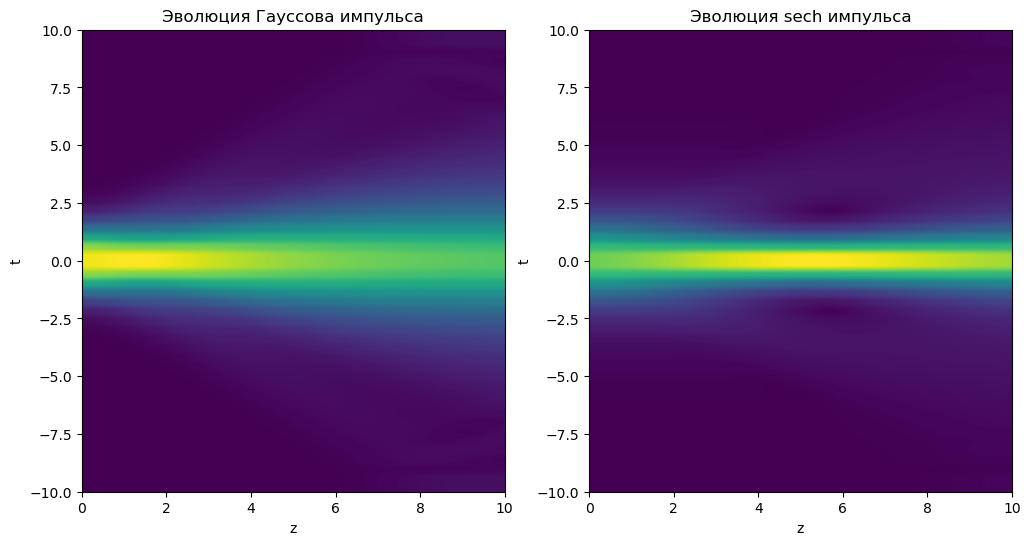

In [263]:
# Решаем для разных начальных условий
u_gauss_sol = solve_NLS(u_gaussian, richardson_scheme, dz, dt, Nz, Nt)
u_sech_sol = solve_NLS(u_sech, richardson_scheme, dz, dt, Nz, Nt)

# Визуализация
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.abs(u_gauss_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция Гауссова импульса")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(122)
plt.imshow(np.abs(u_sech_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция sech импульса")
plt.xlabel("z")
plt.ylabel("t")
plt.show()

## Трехслойная схема

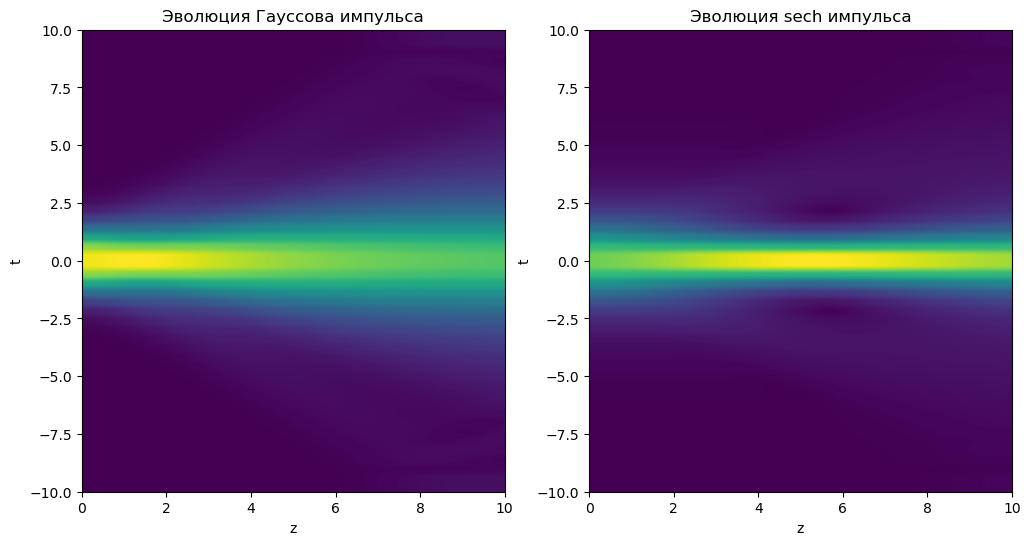

In [264]:
u_gauss_sol = solve_NLS(u_gaussian, three_layer_scheme, dz, dt, Nz, Nt)
u_sech_sol = solve_NLS(u_sech, three_layer_scheme, dz, dt, Nz, Nt)

# Визуализация
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.abs(u_gauss_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция Гауссова импульса")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(122)
plt.imshow(np.abs(u_sech_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция sech импульса")
plt.xlabel("z")
plt.ylabel("t")
plt.show()

# Двухслойной схемы

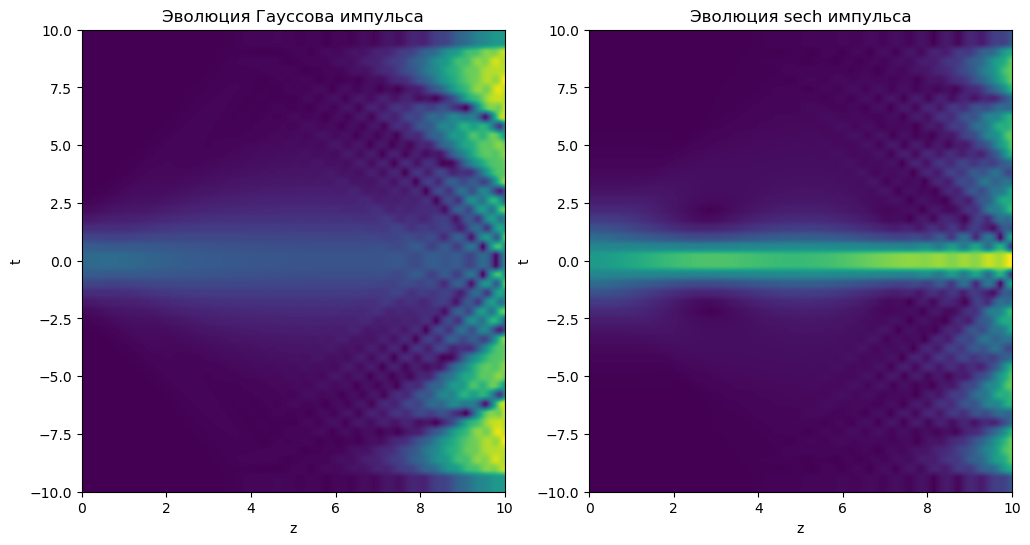

In [265]:
# Решение с двухслойной явной схемой
def solve_unstable(u0, dz, dt, Nz, Nt):
    u = np.zeros((Nz, Nt), dtype=complex)
    u[0] = u0
    
    for n in range(Nz-1):
        u[n+1] = two_layer_explicit(u[n], dt, dz, Nt, Nz)
    
    return u
    
u_gauss_sol = solve_unstable(u_gaussian, dz, dt, Nz, Nt)
u_sech_sol = solve_unstable(u_sech, dz, dt, Nz, Nt)

# Визуализация
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.abs(u_gauss_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция Гауссова импульса")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(122)
plt.imshow(np.abs(u_sech_sol.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Эволюция sech импульса")
plt.xlabel("z")
plt.ylabel("t")
plt.show()

# Анализ результатов
Эволюция начальных распределений:

Гауссов импульс постепенно трансформируется, демонстрируя нелинейные эффекты

Гиперболический секанс с амплитудой 1.2 эволюционирует к фундаментальному солитону

Неустойчивость двухслойной схемы:

На графике видно, как ошибки быстро нарастают с увеличением z

Уже при небольших z решение становится полностью некорректным

Это подтверждает абсолютную неустойчивость явной двухслойной схемы



# Выводы:

Трехслойные схемы позволяют устойчиво моделировать эволюцию начальных распределений к фундаментальному солитону

Двухслойная явная схема демонстрирует абсолютную неустойчивость, что подтверждает необходимость использования более сложных схем

Начальные условия типа sech с амплитудой, отличной от 1, эволюционируют к стабильному солитонному решению



/tmp/ipykernel_218129/414508676.py:60: RuntimeWarning: overflow encountered in scalar multiply
  nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
/tmp/ipykernel_218129/414508676.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  u_next[j] = u_curr[j] - 1j*dz*(0.5*laplacian + nonlinear)
/tmp/ipykernel_218129/414508676.py:60: RuntimeWarning: overflow encountered in scalar power
  nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


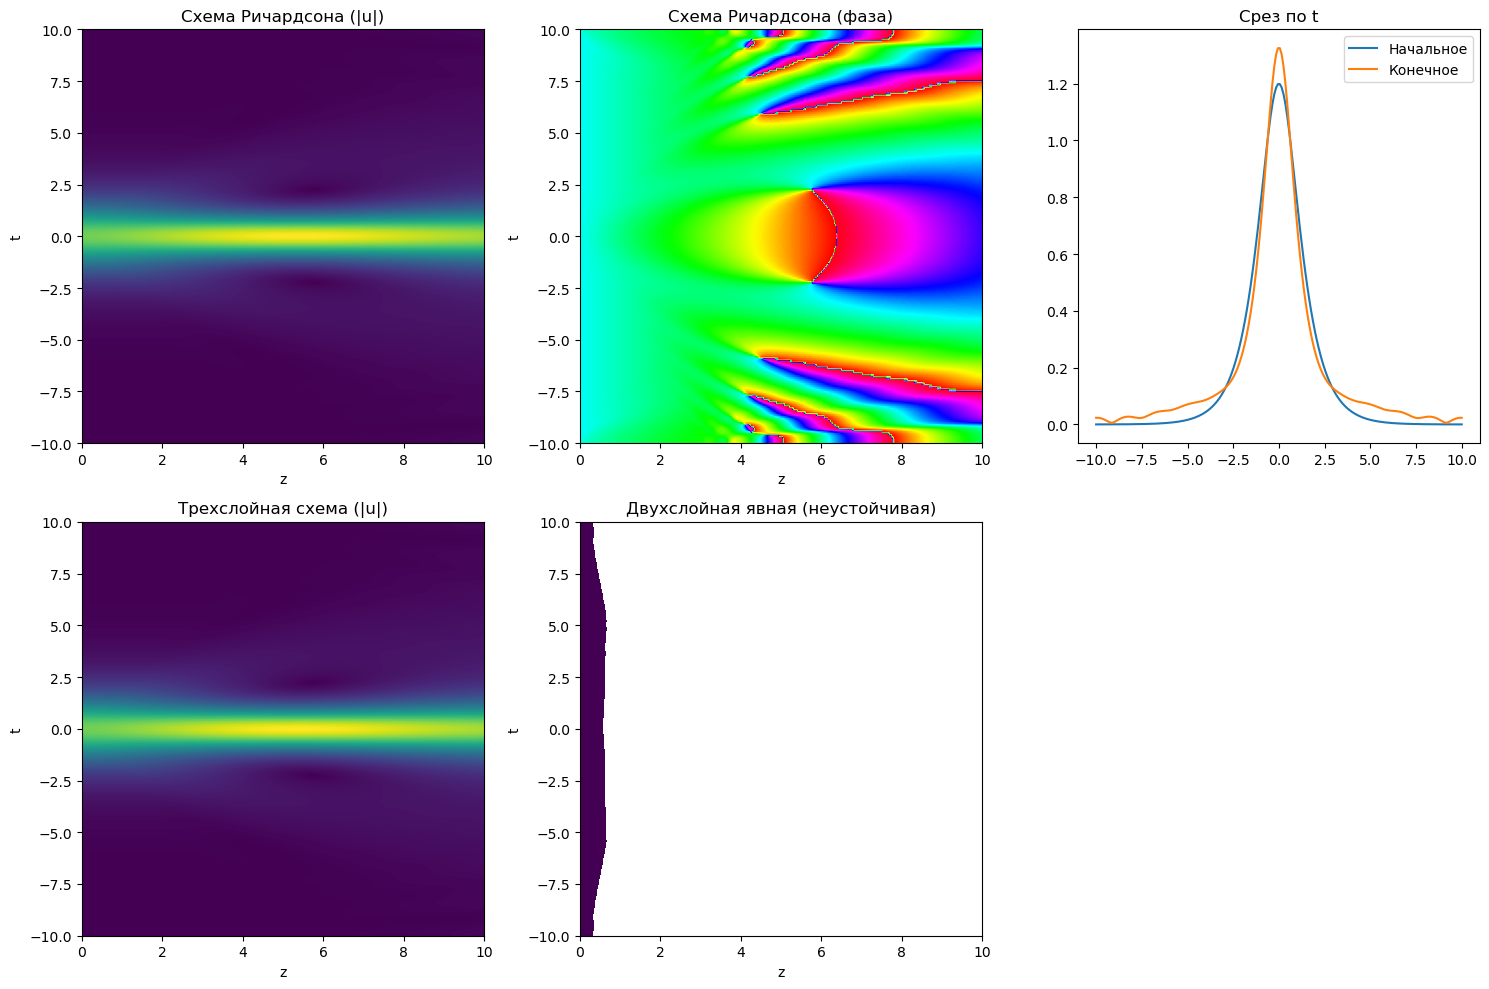

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
Lz = 10.0  # длина по z
Lt = 20.0  # длина по t (от -10 до 10)
Nz = 1000  # количество точек по z
Nt = 200   # количество точек по t
dz = Lz/Nz
dt = Lt/Nt

# Сетка
z = np.linspace(0, Lz, Nz)
t = np.linspace(-Lt/2, Lt/2, Nt)

# Начальные условия
u_gaussian = np.exp(-t**2/2)  # Гауссов импульс
u_sech = 1.2 / np.cosh(t)     # Гиперболический секанс

### 1. Схема Ричардсона (из слайдов) ###
def richardson_scheme(u_prev, u_curr, dt, dz, Nt, Nz):
    u_next = np.zeros_like(u_curr, dtype=complex)
    for j in range(1, Nt-1):
        # Дискретизация производных согласно схеме Ричардсона
        laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
        nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
        
        # Формула схемы Ричардсона (O(τ²,h²))
        u_next[j] = u_prev[j] - 1j*dz*(0.5*laplacian + nonlinear)
    
    # Граничные условия (свободные)
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

### 2. Трехслойная схема с весами (устойчивая) ###
def three_layer_scheme(u_prev, u_curr, dt, dz, Nt, Nz, sigma=0.5):
    u_next = np.zeros_like(u_curr, dtype=complex)
    for j in range(1, Nt-1):
        laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
        nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
        
        u_next[j] = u_prev[j] - 1j*dz*(
            sigma*(0.5*laplacian + nonlinear) + 
            (1-sigma)*(0.5*(u_curr[j+1]-2*u_curr[j]+u_curr[j-1])/dt**2 + np.abs(u_curr[j])**2*u_curr[j])
        )
    
    # Граничные условия
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

### 3. Двухслойная явная схема (неустойчивая) ###
def two_layer_explicit(u_curr, dt, dz, Nt, Nz):
    u_next = np.zeros_like(u_curr, dtype=complex)
    for j in range(1, Nt-1):
        laplacian = (u_curr[j+1] - 2*u_curr[j] + u_curr[j-1])/dt**2
        nonlinear = np.abs(u_curr[j])**2 * u_curr[j]
        u_next[j] = u_curr[j] - 1j*dz*(0.5*laplacian + nonlinear)
    
    # Граничные условия
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    
    return u_next

### Общая функция решения для всех схем ###
def solve_NLS(u0, scheme, dz, dt, Nz, Nt, scheme_type='richardson'):
    u = np.zeros((Nz, Nt), dtype=complex)
    u[0] = u0
    
    if scheme_type == 'richardson' or scheme_type == 'three_layer':
        # Для трехслойных схем нужен дополнительный начальный шаг
        u[1] = u[0]
        for _ in range(10):  # Итерации по нелинейности
            laplacian = (u[0,2:] - 2*u[0,1:-1] + u[0,:-2])/dt**2
            nonlinear = 0.5*(np.abs(u[1,1:-1])**2 + np.abs(u[0,1:-1])**2)*u[1,1:-1]
            u[1,1:-1] = u[0,1:-1] - 1j*dz*(0.5*laplacian + nonlinear)
        
        # Последующие шаги
        for n in range(1, Nz-1):
            u[n+1] = scheme(u[n-1], u[n], dt, dz, Nt, Nz)
    else:
        # Двухслойная схема
        for n in range(Nz-1):
            u[n+1] = scheme(u[n], dt, dz, Nt, Nz)
    
    return u

### Решение и визуализация для всех схем ###

# 1. Схема Ричардсона
u_richardson = solve_NLS(u_sech, richardson_scheme, dz, dt, Nz, Nt, 'richardson')

# 2. Трехслойная схема с весами
u_three_layer = solve_NLS(u_sech, three_layer_scheme, dz, dt, Nz, Nt, 'three_layer')

# 3. Двухслойная явная схема (для демонстрации неустойчивости)
u_two_layer = solve_NLS(u_sech, two_layer_explicit, dz, dt, Nz, Nt, 'two_layer')

# Визуализация результатов
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(np.abs(u_richardson.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Схема Ричардсона (|u|)")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(232)
plt.imshow(np.angle(u_richardson.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto', cmap='hsv')
plt.title("Схема Ричардсона (фаза)")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(233)
plt.plot(t, np.abs(u_richardson[0]), label='Начальное')
plt.plot(t, np.abs(u_richardson[-1]), label='Конечное')
plt.title("Срез по t")
plt.legend()

plt.subplot(234)
plt.imshow(np.abs(u_three_layer.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Трехслойная схема (|u|)")
plt.xlabel("z")
plt.ylabel("t")

plt.subplot(235)
plt.imshow(np.abs(u_two_layer.T), extent=[0,Lz,-Lt/2,Lt/2], aspect='auto')
plt.title("Двухслойная явная (неустойчивая)")
plt.xlabel("z")
plt.ylabel("t")

plt.tight_layout()
plt.show()

In [245]:
! git push

[main d907dab] Update task 5
 1 file changed, 622 insertions(+)
 create mode 100644 lesson_17/task_5.ipynb
